<a href="https://colab.research.google.com/github/canfielder/DSBA-6190_Proj2/blob/master/wine_predict/wine_quality_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of the following colab file is to create export an sklearn model for use in a Flask App. That Flask App will then be containerized with Docker. 

The Wine Quality Dataset (https://archive.ics.uci.edu/ml/datasets/Wine+Quality) was used as the data input. Several regression models were generated, using the provided data to predict red wine quality.

# Import Libraries

In [0]:
#import sys
#!{sys.executable} -m pip install joblib

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Modeling
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Output
from sklearn.metrics import mean_squared_error,r2_score

# Export
import joblib
from google.colab import files

seed = 5590

# Data Import

In [0]:
# URL Shortened Github link
url = 'https://bit.ly/39kKCWZ'
df_wine_red = pd.read_csv(url, sep=";")

# EDA

In [4]:
df_wine_red.shape

(1599, 12)

In [5]:
df_wine_red.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Remove spaces from column names

In [0]:
df_wine_red.columns = df_wine_red.columns.str.replace(' ', '_')

In [7]:
df_wine_red.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
df_wine_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Missing Value Check

In [9]:
df_wine_red.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Inspect Multicollinearity
All of the variables are numeric. We need to verify that there is no multicollinearity.

In [10]:
correlations = df_wine_red.corr()['quality'].drop('quality')
print(correlations)

fixed_acidity           0.124052
volatile_acidity       -0.390558
citric_acid             0.226373
residual_sugar          0.013732
chlorides              -0.128907
free_sulfur_dioxide    -0.050656
total_sulfur_dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


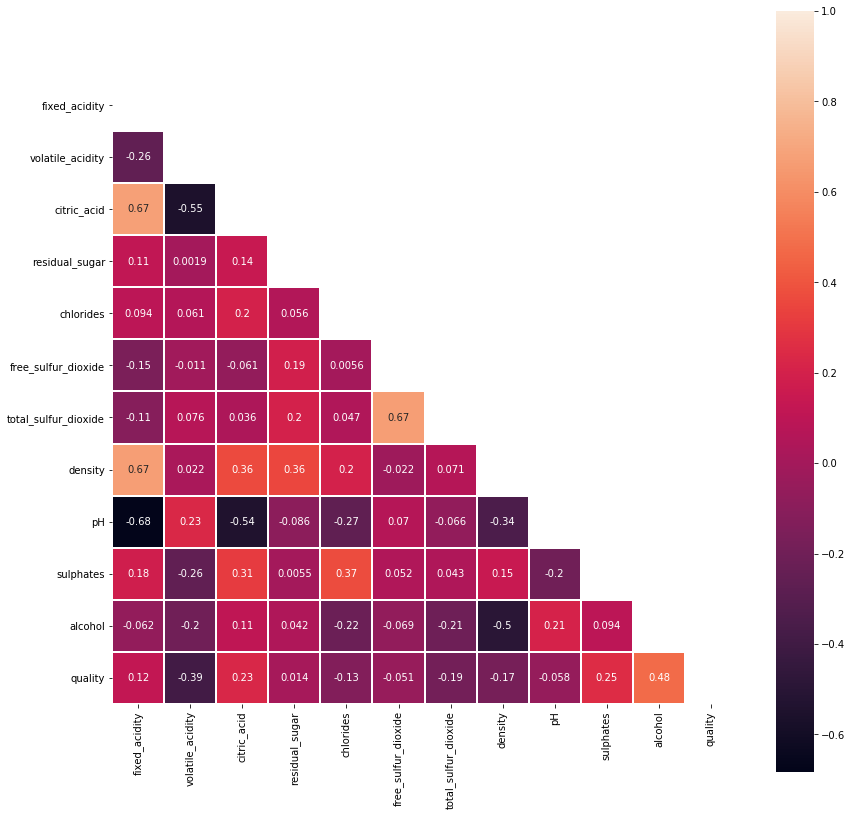

In [11]:
# Create Correlation Object
corr = df_wine_red.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.figure(figsize = (14,14))
sns.heatmap(corr, mask = mask, square=True, linewidths=1, annot=True,)
plt.show()

For now mulitcollinarity will be ignored as this model is just to show how to use a predictive model in a Docker hub. The applicability of the model is not essential.

## Min / Max of Columns
The following calculates the minimum and maximum for each column. this information might be used as a description in the final Flask App, letting the user know the expected range of values.

### Minimum

In [12]:
df_wine_red.min(axis=0)

fixed_acidity           4.60000
volatile_acidity        0.12000
citric_acid             0.00000
residual_sugar          0.90000
chlorides               0.01200
free_sulfur_dioxide     1.00000
total_sulfur_dioxide    6.00000
density                 0.99007
pH                      2.74000
sulphates               0.33000
alcohol                 8.40000
quality                 3.00000
dtype: float64

### Maximum

In [13]:
df_wine_red.max(axis=0)

fixed_acidity            15.90000
volatile_acidity          1.58000
citric_acid               1.00000
residual_sugar           15.50000
chlorides                 0.61100
free_sulfur_dioxide      72.00000
total_sulfur_dioxide    289.00000
density                   1.00369
pH                        4.01000
sulphates                 2.00000
alcohol                  14.90000
quality                   8.00000
dtype: float64


## Anova Report

In [14]:
ols_input = """quality ~ fixed_acidity + volatile_acidity + 
citric_acid + residual_sugar + +chlorides + pH + free_sulfur_dioxide + 
total_sulfur_dioxide + density + sulphates + alcohol"""

results = ols(ols_input, data=df_wine_red).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 16 Feb 2020   Prob (F-statistic):          1.79e-145
Time:                        18:11:11   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               21.9652     21.195      1.036      0.300     -19.607      63.538
fixed_acidity            0.0250      0.026      0.963      0.336      -0.026       0.076
volatile_acidity        -1.0836      0.121     -8.948      0.000      -1.321      -0.846
citric_acid             -0.1826      0.147     -1.240      0.215      -0.471       0.106
residual_sugar           0.0163      0.015      1.089      0.276      -0.013       0.046
chlorides               -1.8742      0.419     -4.470      0.000      -2.697      -1.052
pH                      -0.4137      0.192     -2.159      0.031      -0.789      -0.038
free_sulfur_dioxide      0.0044      0.002      2.009      0.045       0.000       0.009
total_sulfur_dioxide    -0.0033      0.001     -4.480      0.000      -0.005      -0.002
density                -17.8812     21.633     -0.827      0.409     -60.314      24.551
sulphates                0.9163      0.114      8.014      0.000       0.692       1.141
alcohol                  0.2762      0.026     10.429      0.000       0.224       0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## VIF Analysis


### Preparation

In [0]:
# Predictor Variables
df_wine_red_X = df_wine_red.drop('quality', axis=1)

# Gather Features
features = "+".join(df_wine_red_X.columns)

# Return X and y from Multivariable Regression
y, X = dmatrices('quality ~' + features, df_wine_red, return_type='dataframe')

### Analysis

In [16]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,1710538.5,Intercept
1,7.8,fixed_acidity
2,1.8,volatile_acidity
3,3.1,citric_acid
4,1.7,residual_sugar
5,1.5,chlorides
6,2.0,free_sulfur_dioxide
7,2.2,total_sulfur_dioxide
8,6.3,density
9,3.3,pH


# Prepare Data for Modeling

## Seperate Dependent and Independent Variables

In [0]:
y = df_wine_red.quality
X = df_wine_red.drop('quality', axis=1)

In [18]:
X.shape

(1599, 11)

In [19]:
y.shape

(1599,)

## Split Data Into Training and Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=seed, 
                                                    stratify=y)


## Scale Data


In [0]:
scaler = StandardScaler().fit(X_train)

In [22]:
X_train_scaled = scaler.transform(X_train)
 
print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))

[ 5.33323711e-16 -4.02770511e-17  1.11109106e-17 -1.80552298e-17
  1.80552298e-16 -6.11100085e-17 -8.88872852e-17  4.34631047e-14
  1.40344690e-15  3.83326417e-16 -1.23608881e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

[-0.1274238  -0.04357722 -0.06045835 -0.02739073 -0.06217043  0.08601355
  0.12611216 -0.08237321  0.06812566  0.14357303  0.0102217 ]
[0.96539711 1.04651894 0.96743984 0.79423727 0.97446725 1.01210074
 1.04851777 0.9260575  0.95588771 1.17597523 0.98535924]


# Modeling

## Linear Regression

In [0]:
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

### Evaluate

In [25]:
print("RMSE for Linear Regression: %.2f" 
      %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for Linear Regression: %.2f" 
      %np.sqrt(r2_score(y_test,y_pred)))

RMSE for Linear Regression: 0.66
r2 for Linear Regression: 0.57


## Random Forest Regressor

The following block develops a pipeline.

In [26]:
pipeline = make_pipeline(StandardScaler(), 
                         RandomForestRegressor(
                             n_estimators=100, 
                             random_state = seed)
                         )

param_grid = { 
    'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__max_depth': [None, 5, 3, 1]
    }

num_folds = 10

kfold = KFold(n_splits=num_folds)

grid_result = GridSearchCV(
    pipeline,
    param_grid, 
    cv=kfold, 
    refit=True)

grid_result.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                             

In [27]:
print(grid_result.best_params_)
rf_reg = grid_result.best_estimator_

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt'}


In [0]:
y_pred = rf_reg.predict(X_test)

### Evaluate

In [29]:
print("RMSE for  RF Regressor: %.2f" 
      %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for RF Regressor: %.2f" 
      %np.sqrt(r2_score(y_test,y_pred)))

RMSE for  RF Regressor: 0.57
r2 for RF Regressor: 0.71


## Gradient Boost Regression


In [0]:
num_folds = 10

model = GradientBoostingRegressor(random_state=seed)

param_grid={
     'n_estimators': np.linspace(350,500,7).astype(int)
     }

kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=kfold, 
                    refit=True)

grid_result = grid.fit(X_train_scaled, y_train)

In [31]:
print(grid_result.best_params_)
grad_boost_reg = grid_result.best_estimator_

{'n_estimators': 425}


### Grid Search Results

In [32]:
print("Best: %f using %s" % (grid_result.best_score_, 
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.403391 using {'n_estimators': 425}
0.400819 (0.060586) with: {'n_estimators': 350}
0.400972 (0.059810) with: {'n_estimators': 375}
0.401870 (0.062293) with: {'n_estimators': 400}
0.403391 (0.062894) with: {'n_estimators': 425}
0.400781 (0.062862) with: {'n_estimators': 450}
0.399706 (0.064138) with: {'n_estimators': 475}
0.400704 (0.063257) with: {'n_estimators': 500}


### Fit Model

In [0]:
y_pred = grad_boost_reg.predict(X_test_scaled)

### Evaluate

In [34]:
print("RMSE for Linear Regression: %.2f" 
      %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for Linear Regression: %.2f" 
      %np.sqrt(r2_score(y_test,y_pred)))

RMSE for Linear Regression: 0.61
r2 for Linear Regression: 0.65


## Support Vector Machines (SVM) Regression
Note: The poly kernal was previously tested and performed poorly across the board. It has been removde from the parameter grid to speed up future runs.

In [0]:
num_folds = 10

model = SVR()

param_grid={
     'kernel': ('linear', 'rbf'),
     'C':[1, 1.5, 10],
     'gamma': [1e-7, 1e-4],
     'epsilon':[0.1,0.2,0.5,0.3]
     }

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=kfold, 
    refit=True
    )

grid_result = grid.fit(X_train_scaled, y_train)

In [36]:
print(grid_result.best_params_)
svr = grid_result.best_estimator_

{'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}


### Grid Search Results

In [37]:
print("Best: %f using %s" % (grid_result.best_score_, 
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.335980 using {'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}
0.335953 (0.042329) with: {'C': 1, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}
-0.116023 (0.063384) with: {'C': 1, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'rbf'}
0.335953 (0.042329) with: {'C': 1, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.169903 (0.027716) with: {'C': 1, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.333043 (0.039409) with: {'C': 1, 'epsilon': 0.2, 'gamma': 1e-07, 'kernel': 'linear'}
-0.049446 (0.038814) with: {'C': 1, 'epsilon': 0.2, 'gamma': 1e-07, 'kernel': 'rbf'}
0.333043 (0.039409) with: {'C': 1, 'epsilon': 0.2, 'gamma': 0.0001, 'kernel': 'linear'}
0.176934 (0.010763) with: {'C': 1, 'epsilon': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
0.330212 (0.034025) with: {'C': 1, 'epsilon': 0.5, 'gamma': 1e-07, 'kernel': 'linear'}
-0.037432 (0.035594) with: {'C': 1, 'epsilon': 0.5, 'gamma': 1e-07, 'kernel': 'rbf'}
0.330212 (0.034025) with: {'C': 1, 'epsilon': 0.5, 'ga

### Fit Model

In [0]:
y_pred = svr.predict(X_test_scaled)

### Evaluate

In [39]:
print("RMSE for Linear Regression: %.2f" 
      %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for Linear Regression: %.2f" 
      %np.sqrt(r2_score(y_test,y_pred)))

RMSE for Linear Regression: 0.67
r2 for Linear Regression: 0.55


# Pickling Sklearn Model and Scaler
The Random Forest Regressor returned the best model, so we will pickle the model to export for our Flask App.

In [40]:
joblib.dump(rf_reg, 'wine_quality_prediction.joblib')

['wine_quality_prediction.joblib']

In [41]:
scaler_filename = "standard_scalar.joblib"
joblib.dump(scaler, scaler_filename)

['standard_scalar.joblib']

To verify the joblib was created, and verify its location, the following **ls** call is used.

In [42]:
!ls -l

total 3772
drwxr-xr-x 1 root root    4096 Feb  5 18:37 sample_data
-rw-r--r-- 1 root root     839 Feb 16 18:15 standard_scalar.joblib
-rw-r--r-- 1 root root 3852801 Feb 16 18:15 wine_quality_prediction.joblib


## Download Files
The model and files will be manually downloaded to my local machine and then uploaded to Github.


In [0]:
#files.download('wine_quality_prediction.joblib')
#files.download('standard_scalar.joblib')

# Debug
The following information will be created for use in debugging, both for the model and the  the Flask App.

In [0]:
row_num = 125

## Adhoc Predict 1


In [0]:
model = rf_reg

### Input

In [46]:
actual_sample = df_wine_red.iloc[[row_num]]
actual_sample

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
125,9.0,0.62,0.04,1.9,0.146,27.0,90.0,0.9984,3.16,0.7,9.4,5


In [47]:
adhoc_predict_1 = actual_sample.drop('quality', axis=1)
adhoc_predict_1.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
125,9.0,0.62,0.04,1.9,0.146,27.0,90.0,0.9984,3.16,0.7,9.4


### JSON Workflow

In [48]:
json_payload = adhoc_predict_1.to_json()
json_payload

'{"fixed_acidity":{"125":9.0},"volatile_acidity":{"125":0.62},"citric_acid":{"125":0.04},"residual_sugar":{"125":1.9},"chlorides":{"125":0.146},"free_sulfur_dioxide":{"125":27.0},"total_sulfur_dioxide":{"125":90.0},"density":{"125":0.9984},"pH":{"125":3.16},"sulphates":{"125":0.7},"alcohol":{"125":9.4}}'

In [49]:
!ls -l

total 3772
drwxr-xr-x 1 root root    4096 Feb  5 18:37 sample_data
-rw-r--r-- 1 root root     839 Feb 16 18:15 standard_scalar.joblib
-rw-r--r-- 1 root root 3852801 Feb 16 18:15 wine_quality_prediction.joblib


### Scale Input

In [50]:
#scaler = StandardScaler().fit(adhoc_predict_1)
scaled_adhoc_predict_1 = scaler.transform(adhoc_predict_1)
scaled_adhoc_predict_1

array([[ 0.36323039,  0.5111976 , -1.19089158, -0.44166432,  1.22570719,
         1.08433035,  1.36377549,  0.84770255, -0.95734791,  0.28538994,
        -0.95541156]])

### Predict

In [51]:
adhoc_predict_output_1 = model.predict(scaled_adhoc_predict_1).item()
print(adhoc_predict_output_1)

4.93


## Adhoc Predict 2

### Import Joblib

In [0]:
clf = joblib.load('wine_quality_prediction.joblib')

### Input

In [53]:
actual_sample = df_wine_red.iloc[[row_num]]
actual_sample

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
125,9.0,0.62,0.04,1.9,0.146,27.0,90.0,0.9984,3.16,0.7,9.4,5


In [54]:
adhoc_predict_2 = actual_sample.drop('quality', axis=1)
adhoc_predict_2.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
125,9.0,0.62,0.04,1.9,0.146,27.0,90.0,0.9984,3.16,0.7,9.4


### Scale Input

In [55]:
#scaler = StandardScaler().fit(adhoc_predict_2)
scaled_adhoc_predict_2 = scaler.transform(adhoc_predict_2)
scaled_adhoc_predict_2

array([[ 0.36323039,  0.5111976 , -1.19089158, -0.44166432,  1.22570719,
         1.08433035,  1.36377549,  0.84770255, -0.95734791,  0.28538994,
        -0.95541156]])

### Predict


In [56]:
adhoc_predict_output_2 = model.predict(scaled_adhoc_predict_2).item()
adhoc_predict_output_2

4.93

## Verify Adhoc Results

In [57]:
adhoc_predict_output_2 - adhoc_predict_output_1

0.0

# Flask App Check


In [0]:
def scale(payload):
    """Scales Payload"""

    #LOG.info(f"Scaling Payload: {payload}")
    scaler = StandardScaler().fit(payload)
    scaled_adhoc_predict = scaler.transform(payload)
    return scaled_adhoc_predict

In [59]:
  df_init = pd.DataFrame(
    columns=[
        'fixed_acidity', 'volatile_acidity', 'citric_acid',
        'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
        'total_sulfur_dioxide', 'density', 'ph', 'sulphates',
        'alcohol'
    ]
)

print(df_init)

Empty DataFrame
Columns: [fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, ph, sulphates, alcohol]
Index: []


In [60]:
    df_input = df_init.append(
        {
            'fixed_acidity': 1,
            'volatile_acidity': 2,
            'citric_acid': 3,
            'residual_sugar': 4,
            'chlorides': 5,
            'free_sulfur_dioxide': 6,
            'total_sulfur_dioxide': 7,
            'density': 8,
            'ph': 9,
            'sulphates': 10,
            'alcohol': 11
        },
      ignore_index=True
    )

    df_input

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,1,2,3,4,5,6,7,8,9,10,11
